In [2]:
import os
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

In [3]:
def plot_signals(eeg_array):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]

    for sample in range(num_samples):
        plt.figure()
        plt.title(f"Sample {sample}")
        for channel in range(num_channels):
            plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
        # plt.legend()
        plt.show()

In [4]:
def plot_sample(eeg_array, sample, ax, title=None):
    num_channels = eeg_array.shape[1]

    # Plot data on the specified subplot
    ax.plot(eeg_array[sample, :, :].T)
    ax.set_title(f"{title} - Sample {sample}")

In [5]:
def plot_signal(eeg_array, sample, channel):

    num_channels = eeg_array.shape[1]

    plt.figure()
    plt.title(f"Sample {sample}, Channel {channel}")
    plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
    plt.legend()
    plt.show()

In [7]:
def detect_discontinuities(eeg_array, interval=20):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]
    num_signals = eeg_array.shape[2]
    
    discontinuities = []

    for sample in range(num_samples):
        found_discontinuity = False
        
        for channel in range(num_channels):
            for signal in range(num_signals - interval):
                interval_values = eeg_array[sample, channel, signal:signal+interval+1]

                if np.all(interval_values == np.sort(interval_values)) or np.all(interval_values == np.sort(interval_values)[::-1]):
                    if abs(interval_values[0] - interval_values[-1]) < 50:
                        # print(interval_values)
                        # print("Indices: ", signal, signal+interval+1)
                        # plot_signal(eeg_array, sample, channel)
                        discontinuities.append((sample, channel, signal))
                        found_discontinuity = True
                        break

            if found_discontinuity:
                break

    return discontinuities

In [6]:
folder_path = '../data/test_walk_instr_raw/'
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]

file_list.sort()

print(file_list)

['../data/test_walk_instr_raw/P_1.mat', '../data/test_walk_instr_raw/P_10.mat', '../data/test_walk_instr_raw/P_2.mat', '../data/test_walk_instr_raw/P_3.mat', '../data/test_walk_instr_raw/P_4.mat', '../data/test_walk_instr_raw/P_5.mat', '../data/test_walk_instr_raw/P_9.mat', '../data/test_walk_instr_raw/S_1.mat', '../data/test_walk_instr_raw/S_10.mat', '../data/test_walk_instr_raw/S_2.mat', '../data/test_walk_instr_raw/S_3.mat', '../data/test_walk_instr_raw/S_4.mat', '../data/test_walk_instr_raw/S_5.mat', '../data/test_walk_instr_raw/S_9.mat']


In [9]:
discontinuous_files = []

for i, file in enumerate(file_list):
    x = scipy.io.loadmat(file)
    x = x['data']

    print(x.shape)
    
    discontinuities = detect_discontinuities(x, 50)

    if(len(discontinuities) > 0):
        print(discontinuities)
        discontinuous_files.append((file, discontinuities))


(56, 14, 750)
(37, 14, 750)
(49, 14, 750)
(56, 14, 750)
(58, 14, 750)
(57, 14, 750)
(60, 14, 750)
(60, 14, 750)
[(4, 0, 375), (5, 0, 397), (11, 0, 486), (14, 0, 591), (15, 5, 674), (34, 0, 122), (37, 0, 51), (45, 0, 657)]
(67, 14, 750)
(60, 14, 750)
[(16, 0, 618)]
(80, 14, 750)
[(21, 0, 387), (49, 0, 681), (73, 0, 219), (75, 0, 24)]
(79, 14, 750)
[(62, 0, 240)]
(66, 14, 750)
(84, 14, 750)
[(34, 0, 37)]


In [10]:
print(discontinuous_files)
sum = 0
for file in discontinuous_files:
    sum += len(file[1])

print(sum)

[('../data/test_walk_instr_raw/S_1.mat', [(4, 0, 375), (5, 0, 397), (11, 0, 486), (14, 0, 591), (15, 5, 674), (34, 0, 122), (37, 0, 51), (45, 0, 657)]), ('../data/test_walk_instr_raw/S_2.mat', [(16, 0, 618)]), ('../data/test_walk_instr_raw/S_3.mat', [(21, 0, 387), (49, 0, 681), (73, 0, 219), (75, 0, 24)]), ('../data/test_walk_instr_raw/S_4.mat', [(62, 0, 240)]), ('../data/test_walk_instr_raw/S_9.mat', [(34, 0, 37)])]
15


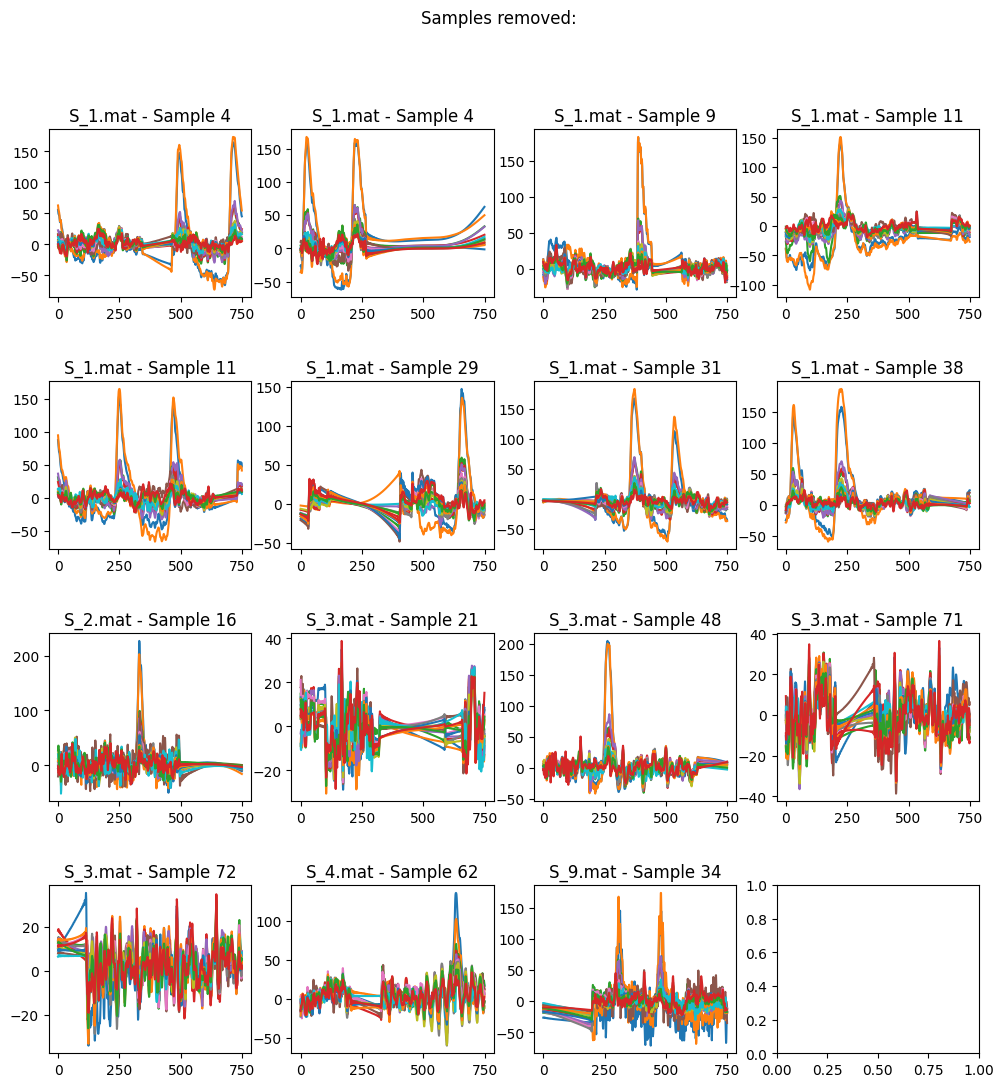

In [12]:
X = []
Y = []

num_graphs = sum
num_rows = (num_graphs + 3) // 4  # Compute the number of subplot rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 3*num_rows))
fig.suptitle("Samples removed:")

subplot_index = 0

for file in file_list:
    x = scipy.io.loadmat(file)
    x = x['data']

    rmv_count = 0

    for discontinuous_file in discontinuous_files:
        if(file == discontinuous_file[0]):
            for discontinuity in discontinuous_file[1]:
                plot_sample(x, discontinuity[0] - rmv_count, axes[subplot_index // 4, subplot_index % 4], title=file.split('/')[-1])
                index = discontinuity[0]
                x = np.delete(x, index-rmv_count, axis=0)
                rmv_count += 1
                subplot_index = (subplot_index + 1) % (4 * num_rows)
    
    # removethe last 250 elements from each trial
    x = x[:,:,:500]

    first_letter = file.split('/')[-1][0]

    # create output vector. If file begins with 'P', then y = [1,0], else y = [0,1], having the same dimension as x
    if first_letter == 'P':
        y = np.zeros((x.shape[0],2))
        y[:,0] = 1
    else:
        y = np.zeros((x.shape[0],2))
        y[:,1] = 1

    X.append(x)
    Y.append(y)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

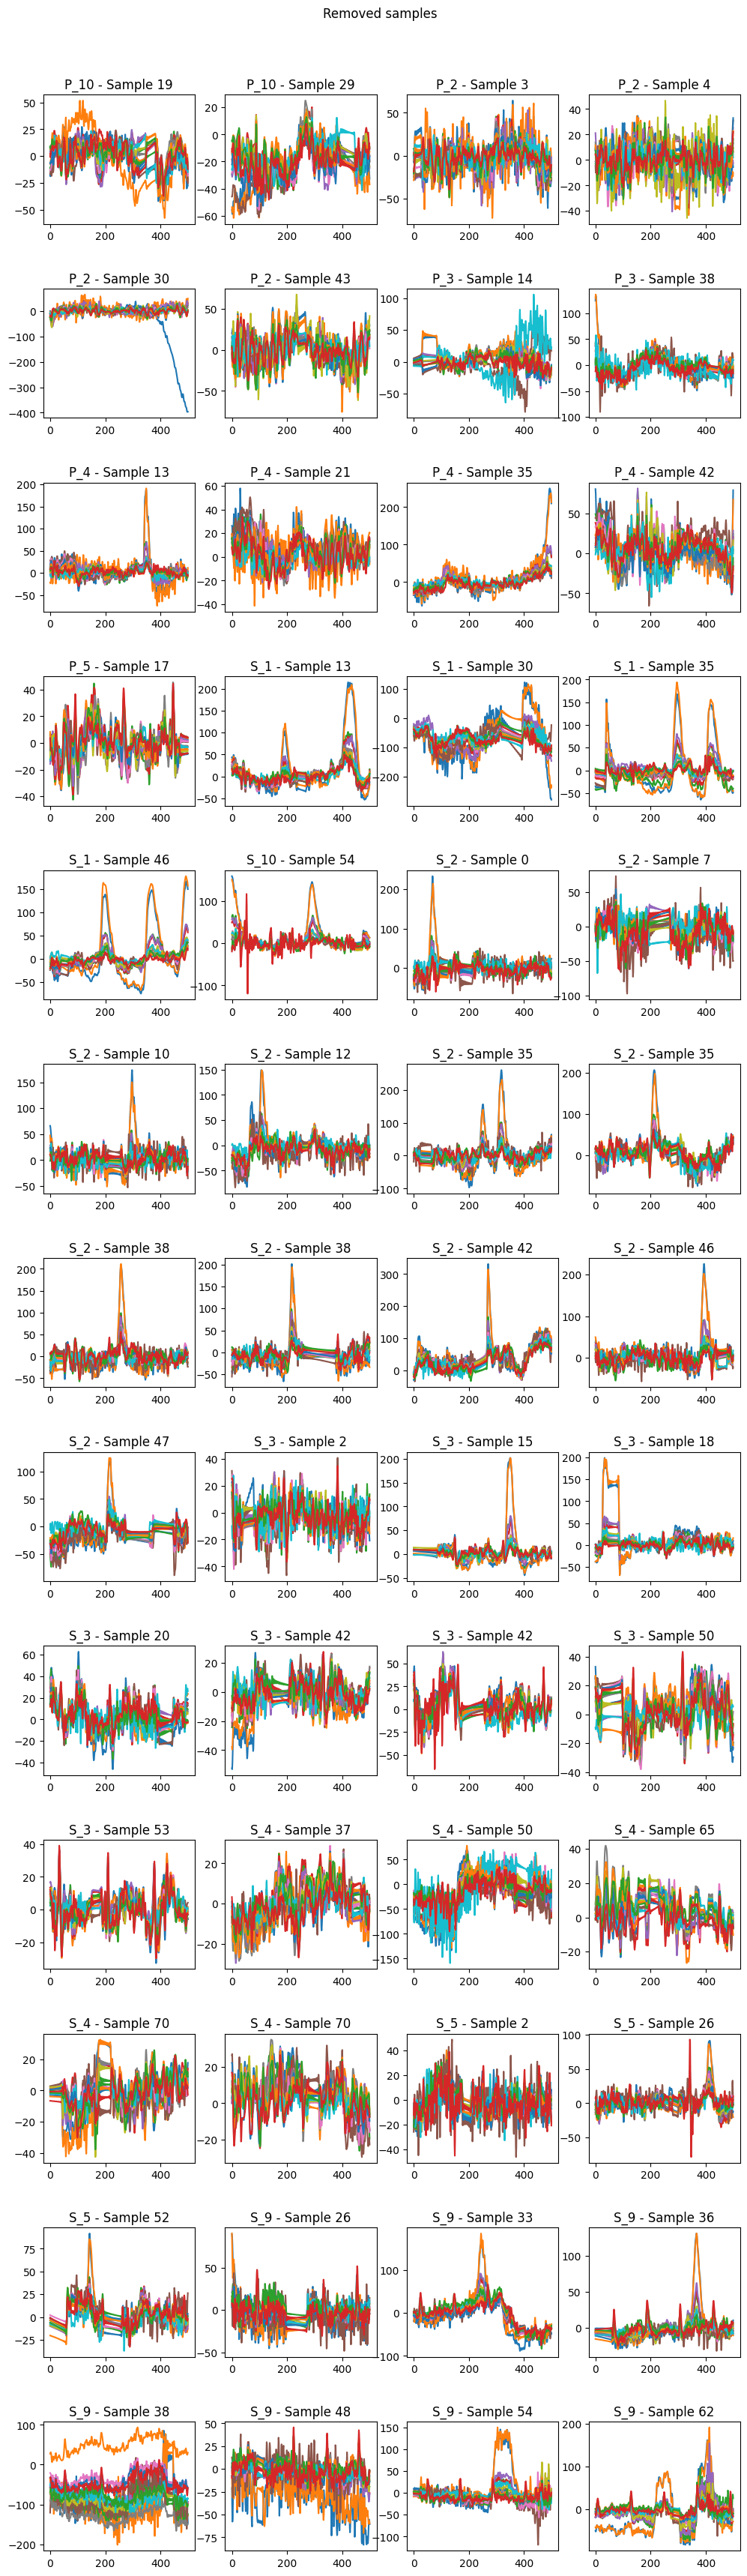

In [13]:
kick_out = [(1, [19, 30]), (2, [3, 5, 32, 46]), (3, [14, 39]), (4, [13, 22, 37, 45]), (5, [17]), (7, [13, 31, 37, 49]),
            (8, [54]), (9, [0, 8, 12, 15, 39, 40, 44, 45, 50, 55, 57]), (10, [2, 16, 20, 23, 46, 47, 56, 60]), (11, [37, 51, 67, 73, 74]), 
            (12, [2, 27, 54]), (13, [26, 34, 38, 41, 52, 59, 68])]

file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

sum2 = 0
for kick in kick_out:
    sum2 += len(kick[1])

num_graphs = sum2
num_rows = (num_graphs + 3) // 4  # Compute the number of subplot rows

subplot_index = 0

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 3*num_rows))
fig.subplots_adjust(top=0.95)
fig.suptitle("Removed samples")

new_X = []
new_Y = []
for i, x in enumerate(X):
    rmv_count = 0
    y = Y[i]
    for kick in kick_out:
        if i == kick[0]:
            for index in kick[1]:
                plot_sample(x, index - rmv_count, axes[subplot_index // 4, subplot_index % 4], title=file_dict[i])
                x = np.delete(x, index-rmv_count, axis=0)
                y = np.delete(y, index-rmv_count, axis=0)
                rmv_count += 1
                subplot_index = (subplot_index + 1) % (4 * num_rows)

    new_X.append(x)
    new_Y.append(y)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)
    
    

In [20]:
total_elim = 0
total_samples = 0
for i, file in enumerate(file_list):
    new_x = new_X[i]
    new_y = new_Y[i]
    old_x = scipy.io.loadmat(file)['data']
    print( old_x.shape, "->", new_x.shape, new_y.shape)
    total_samples += new_x.shape[0]
    total_elim += old_x.shape[0] - new_x.shape[0]

print("Total samples removed: ", total_elim)
print("Total samples remaining: ", total_samples)

(56, 14, 750) -> (56, 14, 500) (56, 2)
(37, 14, 750) -> (35, 14, 500) (35, 2)
(49, 14, 750) -> (45, 14, 500) (45, 2)
(56, 14, 750) -> (54, 14, 500) (54, 2)
(58, 14, 750) -> (54, 14, 500) (54, 2)
(57, 14, 750) -> (56, 14, 500) (56, 2)
(60, 14, 750) -> (60, 14, 500) (60, 2)
(60, 14, 750) -> (48, 14, 500) (48, 2)
(67, 14, 750) -> (66, 14, 500) (66, 2)
(60, 14, 750) -> (48, 14, 500) (48, 2)
(80, 14, 750) -> (68, 14, 500) (68, 2)
(79, 14, 750) -> (73, 14, 500) (73, 2)
(66, 14, 750) -> (63, 14, 500) (63, 2)
(84, 14, 750) -> (76, 14, 500) (76, 2)
Total samples removed:  67
Total samples remaining:  802


In [17]:
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score

In [18]:
kernels, chans, samples = 1, 14, 500

Accuracies = []
p_acc = []
s_acc = []

for index_1 in range(0, 7):
    for index_2 in range(7, 14):
        # build training set from allfiles expect the ones with index_1 and index_2
        X_train = [new_X[i] for i in range(len(new_X)) if i != index_1 and i != index_2]
        Y_train = [new_Y[i] for i in range(len(new_Y)) if i != index_1 and i != index_2]

        # build test set from the files with index_1 and index_2
        X_test = [new_X[i] for i in range(len(new_X)) if i == index_1 or i == index_2]
        Y_test = [new_Y[i] for i in range(len(new_Y)) if i == index_1 or i == index_2]

        X_train = np.concatenate(X_train)
        Y_train = np.concatenate(Y_train)

        # convert data to NHWC (trials, channels, samples, kernels) format.
        X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)

        model = EEGNet(nb_classes=2, Chans=chans, Samples=samples, dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16, dropoutType='Dropout')

        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

        # count number of parameters in the model
        numParams    = model.count_params()     

        # set a valid path for the system to record model checkpoints
        # checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

        class_weights = {0:1, 1:1}

        fitted_model = model.fit(X_train, Y_train, batch_size = 32, epochs = 50, verbose = 2, 
                                class_weight=class_weights)
        
        #open file to write results in
        f = open("../results/results_trimmed_capped_walk_instr_raw.txt", "a") 

        # make prediction on the 2 test files individually
        X_test_1 = X_test[0].reshape(X_test[0].shape[0], chans, samples, kernels)
        X_test_2 = X_test[1].reshape(X_test[1].shape[0], chans, samples, kernels)

        probs_1 = model.predict(X_test_1)
        probs_2 = model.predict(X_test_2)
        preds_1 = probs_1.argmax(axis = -1)
        preds_2 = probs_2.argmax(axis = -1)
        acc_1 = balanced_accuracy_score(Y_test[0].argmax(axis=-1), preds_1)
        acc_2 = balanced_accuracy_score(Y_test[1].argmax(axis=-1), preds_2)
        f.write("----------------------SELECTED FILES: %d and %d---------------------\n" % (index_1, index_2))
        f.write("Classification accuracy for P: %f \n" % (acc_1))
        f.write("Classification accuracy for S: %f \n" % (acc_2))

        p_acc.append(acc_1)
        s_acc.append(acc_2)

        # make prediction on the 2 test files together
        X_test = np.concatenate(X_test)
        X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        Y_test = np.concatenate(Y_test)


        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)
        acc         = balanced_accuracy_score(Y_test.argmax(axis=-1), preds)
        f.write("Classification accuracy for P and S: %f \n" % (acc))
        f.write("\n")

        f.close()

        Accuracies.append(acc)

print("Mean classification accuracy: %f " % (np.mean(Accuracies)))

Epoch 1/50
24/24 - 7s - loss: 0.6961 - accuracy: 0.5402 - 7s/epoch - 274ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6690 - accuracy: 0.5670 - 3s/epoch - 144ms/step
Epoch 3/50
24/24 - 4s - loss: 0.6528 - accuracy: 0.6233 - 4s/epoch - 152ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6417 - accuracy: 0.6367 - 3s/epoch - 145ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6099 - accuracy: 0.7078 - 3s/epoch - 141ms/step
Epoch 6/50
24/24 - 4s - loss: 0.5934 - accuracy: 0.7252 - 4s/epoch - 147ms/step
Epoch 7/50
24/24 - 4s - loss: 0.5689 - accuracy: 0.7386 - 4s/epoch - 150ms/step
Epoch 8/50
24/24 - 4s - loss: 0.5311 - accuracy: 0.7534 - 4s/epoch - 146ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5047 - accuracy: 0.8083 - 4s/epoch - 148ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5006 - accuracy: 0.7842 - 3s/epoch - 140ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4489 - accuracy: 0.8338 - 3s/epoch - 136ms/step
Epoch 12/50
24/24 - 3s - loss: 0.4097 - accuracy: 0.8512 - 3s/epoch - 143ms/step
Epoch 13/50
24/24 - 3s - loss: 0.4005

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6803 - accuracy: 0.5691 - 6s/epoch - 272ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6466 - accuracy: 0.6019 - 3s/epoch - 142ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6370 - accuracy: 0.6389 - 3s/epoch - 141ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6244 - accuracy: 0.6648 - 3s/epoch - 147ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6211 - accuracy: 0.6539 - 3s/epoch - 146ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6156 - accuracy: 0.6648 - 3s/epoch - 141ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6090 - accuracy: 0.6689 - 3s/epoch - 140ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5993 - accuracy: 0.6799 - 3s/epoch - 141ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5880 - accuracy: 0.7059 - 3s/epoch - 139ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5950 - accuracy: 0.7004 - 3s/epoch - 139ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5788 - accuracy: 0.7004 - 3s/epoch - 143ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5784 - accuracy: 0.7291 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6900 - accuracy: 0.5440 - 7s/epoch - 274ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6594 - accuracy: 0.6022 - 3s/epoch - 142ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6409 - accuracy: 0.6428 - 3s/epoch - 142ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6057 - accuracy: 0.6874 - 3s/epoch - 146ms/step
Epoch 5/50
24/24 - 4s - loss: 0.6079 - accuracy: 0.6779 - 4s/epoch - 147ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5761 - accuracy: 0.6982 - 3s/epoch - 142ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5534 - accuracy: 0.6982 - 3s/epoch - 140ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5634 - accuracy: 0.6955 - 3s/epoch - 139ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5619 - accuracy: 0.7023 - 3s/epoch - 136ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5358 - accuracy: 0.7294 - 3s/epoch - 136ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5239 - accuracy: 0.7307 - 3s/epoch - 141ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5242 - accuracy: 0.7253 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6998 - accuracy: 0.5512 - 6s/epoch - 270ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6642 - accuracy: 0.6080 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6415 - accuracy: 0.6648 - 3s/epoch - 127ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6267 - accuracy: 0.6634 - 3s/epoch - 124ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6039 - accuracy: 0.6911 - 3s/epoch - 124ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5983 - accuracy: 0.6967 - 3s/epoch - 127ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5839 - accuracy: 0.7175 - 3s/epoch - 123ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5756 - accuracy: 0.7105 - 3s/epoch - 125ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5564 - accuracy: 0.7452 - 3s/epoch - 126ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5312 - accuracy: 0.7701 - 3s/epoch - 127ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5086 - accuracy: 0.7729 - 3s/epoch - 130ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4778 - accuracy: 0.8130 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 23ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6953 - accuracy: 0.5264 - 6s/epoch - 253ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6573 - accuracy: 0.6014 - 3s/epoch - 144ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6414 - accuracy: 0.6278 - 3s/epoch - 148ms/step
Epoch 4/50
23/23 - 4s - loss: 0.6277 - accuracy: 0.6375 - 4s/epoch - 159ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6140 - accuracy: 0.6819 - 3s/epoch - 149ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6061 - accuracy: 0.6931 - 3s/epoch - 140ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5966 - accuracy: 0.6986 - 3s/epoch - 143ms/step
Epoch 8/50
23/23 - 4s - loss: 0.5919 - accuracy: 0.7042 - 4s/epoch - 153ms/step
Epoch 9/50
23/23 - 4s - loss: 0.5976 - accuracy: 0.7181 - 4s/epoch - 157ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5832 - accuracy: 0.7097 - 3s/epoch - 147ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5887 - accuracy: 0.7083 - 3s/epoch - 149ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5696 - accuracy: 0.7306 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6957 - accuracy: 0.5451 - 6s/epoch - 258ms/step
Epoch 2/50
23/23 - 4s - loss: 0.6515 - accuracy: 0.6038 - 4s/epoch - 153ms/step
Epoch 3/50
23/23 - 4s - loss: 0.6368 - accuracy: 0.6216 - 4s/epoch - 160ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6283 - accuracy: 0.6462 - 3s/epoch - 142ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6239 - accuracy: 0.6544 - 3s/epoch - 145ms/step
Epoch 6/50
23/23 - 4s - loss: 0.6021 - accuracy: 0.6995 - 4s/epoch - 161ms/step
Epoch 7/50
23/23 - 4s - loss: 0.5969 - accuracy: 0.6831 - 4s/epoch - 157ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5929 - accuracy: 0.7186 - 3s/epoch - 148ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5896 - accuracy: 0.7022 - 3s/epoch - 137ms/step
Epoch 10/50
23/23 - 4s - loss: 0.5765 - accuracy: 0.7404 - 4s/epoch - 154ms/step
Epoch 11/50
23/23 - 4s - loss: 0.5767 - accuracy: 0.7090 - 4s/epoch - 159ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5578 - accuracy: 0.7432 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 26ms/step
Epoch 1/50
23/23 - 5s - loss: 0.7024 - accuracy: 0.5469 - 5s/epoch - 234ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6483 - accuracy: 0.6294 - 3s/epoch - 132ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6295 - accuracy: 0.6587 - 3s/epoch - 133ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6096 - accuracy: 0.6993 - 3s/epoch - 125ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5961 - accuracy: 0.6979 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5790 - accuracy: 0.7217 - 3s/epoch - 139ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5554 - accuracy: 0.7510 - 3s/epoch - 125ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5451 - accuracy: 0.7413 - 3s/epoch - 123ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5060 - accuracy: 0.7776 - 3s/epoch - 130ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5034 - accuracy: 0.7636 - 3s/epoch - 133ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4568 - accuracy: 0.8084 - 3s/epoch - 138ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3941 - accuracy: 0.8671 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 21ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6924 - accuracy: 0.5673 - 6s/epoch - 254ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6564 - accuracy: 0.6235 - 3s/epoch - 128ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6323 - accuracy: 0.6458 - 3s/epoch - 126ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6215 - accuracy: 0.6536 - 3s/epoch - 128ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6081 - accuracy: 0.6954 - 3s/epoch - 128ms/step
Epoch 6/50
24/24 - 3s - loss: 0.6014 - accuracy: 0.6837 - 3s/epoch - 134ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5796 - accuracy: 0.7085 - 3s/epoch - 139ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5944 - accuracy: 0.6967 - 3s/epoch - 139ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5789 - accuracy: 0.7098 - 3s/epoch - 139ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5741 - accuracy: 0.7268 - 3s/epoch - 136ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5667 - accuracy: 0.7294 - 3s/epoch - 138ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5600 - accuracy: 0.7281 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


3/3 [==============================] - 0s 27ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6897 - accuracy: 0.5493 - 7s/epoch - 288ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6268 - accuracy: 0.6813 - 3s/epoch - 136ms/step
Epoch 3/50
24/24 - 4s - loss: 0.6038 - accuracy: 0.6973 - 4s/epoch - 180ms/step
Epoch 4/50
24/24 - 4s - loss: 0.5928 - accuracy: 0.7013 - 4s/epoch - 171ms/step
Epoch 5/50
24/24 - 4s - loss: 0.5779 - accuracy: 0.7253 - 4s/epoch - 163ms/step
Epoch 6/50
24/24 - 4s - loss: 0.5703 - accuracy: 0.7200 - 4s/epoch - 158ms/step
Epoch 7/50
24/24 - 4s - loss: 0.5613 - accuracy: 0.7253 - 4s/epoch - 169ms/step
Epoch 8/50
24/24 - 4s - loss: 0.5578 - accuracy: 0.7507 - 4s/epoch - 153ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5601 - accuracy: 0.7373 - 4s/epoch - 161ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5639 - accuracy: 0.7227 - 3s/epoch - 141ms/step
Epoch 11/50
24/24 - 4s - loss: 0.5412 - accuracy: 0.7533 - 4s/epoch - 147ms/step
Epoch 12/50
24/24 - 4s - loss: 0.5474 - accuracy: 0.7533 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6956 - accuracy: 0.5198 - 6s/epoch - 251ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6590 - accuracy: 0.6069 - 3s/epoch - 136ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6257 - accuracy: 0.6807 - 3s/epoch - 135ms/step
Epoch 4/50
24/24 - 3s - loss: 0.5867 - accuracy: 0.7322 - 3s/epoch - 134ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5477 - accuracy: 0.7348 - 3s/epoch - 135ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5229 - accuracy: 0.7573 - 3s/epoch - 132ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5110 - accuracy: 0.7573 - 3s/epoch - 136ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5067 - accuracy: 0.7559 - 3s/epoch - 137ms/step
Epoch 9/50
24/24 - 3s - loss: 0.4736 - accuracy: 0.7810 - 3s/epoch - 134ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4470 - accuracy: 0.7968 - 3s/epoch - 138ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4453 - accuracy: 0.7968 - 3s/epoch - 135ms/step
Epoch 12/50
24/24 - 3s - loss: 0.4290 - accuracy: 0.8140 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


3/3 [==============================] - 0s 32ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6952 - accuracy: 0.5439 - 6s/epoch - 248ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6332 - accuracy: 0.6478 - 3s/epoch - 136ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6130 - accuracy: 0.6923 - 3s/epoch - 139ms/step
Epoch 4/50
24/24 - 3s - loss: 0.5912 - accuracy: 0.6734 - 3s/epoch - 132ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5780 - accuracy: 0.7247 - 3s/epoch - 135ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5683 - accuracy: 0.7449 - 3s/epoch - 138ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5749 - accuracy: 0.7314 - 3s/epoch - 130ms/step
Epoch 8/50
24/24 - 4s - loss: 0.5431 - accuracy: 0.7382 - 4s/epoch - 160ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5453 - accuracy: 0.7557 - 4s/epoch - 158ms/step
Epoch 10/50
24/24 - 4s - loss: 0.5330 - accuracy: 0.7422 - 4s/epoch - 154ms/step
Epoch 11/50
24/24 - 4s - loss: 0.5310 - accuracy: 0.7544 - 4s/epoch - 149ms/step
Epoch 12/50
24/24 - 4s - loss: 0.5226 - accuracy: 0.7625 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 30ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6960 - accuracy: 0.5304 - 7s/epoch - 293ms/step
Epoch 2/50
24/24 - 4s - loss: 0.6502 - accuracy: 0.6509 - 4s/epoch - 157ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6391 - accuracy: 0.6631 - 3s/epoch - 139ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6095 - accuracy: 0.6779 - 3s/epoch - 132ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6016 - accuracy: 0.6955 - 3s/epoch - 133ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5899 - accuracy: 0.7037 - 3s/epoch - 134ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5757 - accuracy: 0.7104 - 3s/epoch - 133ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5680 - accuracy: 0.7253 - 3s/epoch - 135ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5397 - accuracy: 0.7510 - 3s/epoch - 126ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5301 - accuracy: 0.7524 - 3s/epoch - 124ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5191 - accuracy: 0.7578 - 3s/epoch - 128ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5045 - accuracy: 0.7578 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6913 - accuracy: 0.5553 - 7s/epoch - 283ms/step
Epoch 2/50
24/24 - 4s - loss: 0.6500 - accuracy: 0.6312 - 4s/epoch - 156ms/step
Epoch 3/50
24/24 - 4s - loss: 0.6327 - accuracy: 0.6378 - 4s/epoch - 158ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6039 - accuracy: 0.6991 - 3s/epoch - 135ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5977 - accuracy: 0.7150 - 3s/epoch - 131ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5764 - accuracy: 0.7204 - 3s/epoch - 128ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5556 - accuracy: 0.7377 - 3s/epoch - 133ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5156 - accuracy: 0.7483 - 3s/epoch - 134ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5081 - accuracy: 0.7457 - 3s/epoch - 139ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4843 - accuracy: 0.7563 - 3s/epoch - 139ms/step
Epoch 11/50
24/24 - 4s - loss: 0.4855 - accuracy: 0.7696 - 4s/epoch - 150ms/step
Epoch 12/50
24/24 - 4s - loss: 0.4721 - accuracy: 0.7803 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 7s - loss: 0.6993 - accuracy: 0.5872 - 7s/epoch - 321ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6468 - accuracy: 0.6567 - 3s/epoch - 139ms/step
Epoch 3/50
23/23 - 4s - loss: 0.6383 - accuracy: 0.6717 - 4s/epoch - 157ms/step
Epoch 4/50
23/23 - 4s - loss: 0.6120 - accuracy: 0.6649 - 4s/epoch - 158ms/step
Epoch 5/50
23/23 - 4s - loss: 0.5890 - accuracy: 0.7166 - 4s/epoch - 171ms/step
Epoch 6/50
23/23 - 4s - loss: 0.5674 - accuracy: 0.7384 - 4s/epoch - 153ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5255 - accuracy: 0.7561 - 3s/epoch - 130ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4817 - accuracy: 0.7684 - 3s/epoch - 141ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4275 - accuracy: 0.8120 - 3s/epoch - 137ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4015 - accuracy: 0.8215 - 3s/epoch - 143ms/step
Epoch 11/50
23/23 - 3s - loss: 0.3878 - accuracy: 0.8447 - 3s/epoch - 144ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3525 - accuracy: 0.8556 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6981 - accuracy: 0.5365 - 7s/epoch - 283ms/step
Epoch 2/50
24/24 - 4s - loss: 0.6649 - accuracy: 0.5830 - 4s/epoch - 160ms/step
Epoch 3/50
24/24 - 4s - loss: 0.6399 - accuracy: 0.6521 - 4s/epoch - 150ms/step
Epoch 4/50
24/24 - 4s - loss: 0.6280 - accuracy: 0.6587 - 4s/epoch - 160ms/step
Epoch 5/50
24/24 - 4s - loss: 0.6006 - accuracy: 0.6799 - 4s/epoch - 158ms/step
Epoch 6/50
24/24 - 4s - loss: 0.6004 - accuracy: 0.7039 - 4s/epoch - 156ms/step
Epoch 7/50
24/24 - 4s - loss: 0.5971 - accuracy: 0.7025 - 4s/epoch - 155ms/step
Epoch 8/50
24/24 - 4s - loss: 0.5851 - accuracy: 0.7025 - 4s/epoch - 150ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5667 - accuracy: 0.7317 - 4s/epoch - 152ms/step
Epoch 10/50
24/24 - 4s - loss: 0.5690 - accuracy: 0.7251 - 4s/epoch - 165ms/step
Epoch 11/50
24/24 - 4s - loss: 0.5508 - accuracy: 0.7357 - 4s/epoch - 157ms/step
Epoch 12/50
24/24 - 4s - loss: 0.5435 - accuracy: 0.7463 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 22ms/step
Epoch 1/50
24/24 - 7s - loss: 0.6823 - accuracy: 0.5569 - 7s/epoch - 306ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6568 - accuracy: 0.6030 - 3s/epoch - 144ms/step
Epoch 3/50
24/24 - 4s - loss: 0.6365 - accuracy: 0.6491 - 4s/epoch - 163ms/step
Epoch 4/50
24/24 - 4s - loss: 0.6252 - accuracy: 0.7019 - 4s/epoch - 160ms/step
Epoch 5/50
24/24 - 4s - loss: 0.6113 - accuracy: 0.6897 - 4s/epoch - 166ms/step
Epoch 6/50
24/24 - 4s - loss: 0.5949 - accuracy: 0.7019 - 4s/epoch - 156ms/step
Epoch 7/50
24/24 - 4s - loss: 0.5898 - accuracy: 0.7168 - 4s/epoch - 168ms/step
Epoch 8/50
24/24 - 4s - loss: 0.5841 - accuracy: 0.7060 - 4s/epoch - 165ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5778 - accuracy: 0.7033 - 4s/epoch - 180ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5758 - accuracy: 0.7290 - 3s/epoch - 145ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5620 - accuracy: 0.7371 - 3s/epoch - 127ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5663 - accuracy: 0.7168 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 5s - loss: 0.6936 - accuracy: 0.5763 - 5s/epoch - 237ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6512 - accuracy: 0.5983 - 3s/epoch - 126ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6461 - accuracy: 0.6080 - 3s/epoch - 126ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6119 - accuracy: 0.6520 - 3s/epoch - 125ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6107 - accuracy: 0.6795 - 3s/epoch - 125ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6185 - accuracy: 0.6547 - 3s/epoch - 128ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6049 - accuracy: 0.6754 - 3s/epoch - 129ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5842 - accuracy: 0.6960 - 3s/epoch - 131ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5781 - accuracy: 0.7331 - 3s/epoch - 140ms/step
Epoch 10/50
23/23 - 4s - loss: 0.5792 - accuracy: 0.7070 - 4s/epoch - 170ms/step
Epoch 11/50
23/23 - 4s - loss: 0.5790 - accuracy: 0.7221 - 4s/epoch - 166ms/step
Epoch 12/50
23/23 - 4s - loss: 0.5625 - accuracy: 0.7125 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 30ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6851 - accuracy: 0.5575 - 6s/epoch - 240ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6517 - accuracy: 0.6590 - 3s/epoch - 125ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6414 - accuracy: 0.6455 - 3s/epoch - 128ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6287 - accuracy: 0.6617 - 3s/epoch - 129ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6137 - accuracy: 0.6793 - 3s/epoch - 131ms/step
Epoch 6/50
24/24 - 3s - loss: 0.6074 - accuracy: 0.6861 - 3s/epoch - 133ms/step
Epoch 7/50
24/24 - 3s - loss: 0.6010 - accuracy: 0.6982 - 3s/epoch - 133ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5977 - accuracy: 0.6793 - 3s/epoch - 128ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5912 - accuracy: 0.6982 - 3s/epoch - 127ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5726 - accuracy: 0.7077 - 3s/epoch - 141ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5665 - accuracy: 0.7456 - 3s/epoch - 127ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5302 - accuracy: 0.7632 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 7s - loss: 0.6875 - accuracy: 0.5443 - 7s/epoch - 317ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6612 - accuracy: 0.6330 - 3s/epoch - 143ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6559 - accuracy: 0.6274 - 3s/epoch - 144ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6415 - accuracy: 0.6579 - 3s/epoch - 143ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6187 - accuracy: 0.6884 - 3s/epoch - 145ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5881 - accuracy: 0.7091 - 3s/epoch - 145ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5678 - accuracy: 0.7313 - 3s/epoch - 145ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5092 - accuracy: 0.7687 - 3s/epoch - 142ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5040 - accuracy: 0.7701 - 3s/epoch - 142ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4562 - accuracy: 0.8116 - 3s/epoch - 144ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4503 - accuracy: 0.8019 - 3s/epoch - 143ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4114 - accuracy: 0.8476 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6769 - accuracy: 0.5938 - 6s/epoch - 253ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6514 - accuracy: 0.5925 - 3s/epoch - 138ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6327 - accuracy: 0.6622 - 3s/epoch - 137ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6147 - accuracy: 0.6783 - 3s/epoch - 137ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5939 - accuracy: 0.7024 - 3s/epoch - 139ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5736 - accuracy: 0.7252 - 3s/epoch - 139ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5495 - accuracy: 0.7493 - 3s/epoch - 142ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5229 - accuracy: 0.7708 - 3s/epoch - 144ms/step
Epoch 9/50
24/24 - 3s - loss: 0.4661 - accuracy: 0.8110 - 3s/epoch - 137ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4439 - accuracy: 0.8177 - 3s/epoch - 134ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4030 - accuracy: 0.8405 - 3s/epoch - 143ms/step
Epoch 12/50
24/24 - 3s - loss: 0.3611 - accuracy: 0.8673 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 29ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6753 - accuracy: 0.5896 - 6s/epoch - 258ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6175 - accuracy: 0.6662 - 3s/epoch - 138ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6076 - accuracy: 0.6580 - 3s/epoch - 141ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5750 - accuracy: 0.7168 - 3s/epoch - 138ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5601 - accuracy: 0.7291 - 3s/epoch - 139ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5632 - accuracy: 0.7346 - 3s/epoch - 137ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5512 - accuracy: 0.7278 - 3s/epoch - 139ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5360 - accuracy: 0.7497 - 3s/epoch - 137ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5316 - accuracy: 0.7456 - 3s/epoch - 138ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5270 - accuracy: 0.7647 - 3s/epoch - 140ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5101 - accuracy: 0.7661 - 3s/epoch - 142ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5128 - accuracy: 0.7729 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6873 - accuracy: 0.5751 - 6s/epoch - 251ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6334 - accuracy: 0.6685 - 3s/epoch - 133ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6195 - accuracy: 0.6806 - 3s/epoch - 140ms/step
Epoch 4/50
24/24 - 4s - loss: 0.6206 - accuracy: 0.6793 - 4s/epoch - 147ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6073 - accuracy: 0.6982 - 3s/epoch - 137ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5735 - accuracy: 0.7334 - 3s/epoch - 132ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5630 - accuracy: 0.7334 - 3s/epoch - 137ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5319 - accuracy: 0.7578 - 3s/epoch - 135ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5069 - accuracy: 0.7794 - 3s/epoch - 133ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4893 - accuracy: 0.7794 - 3s/epoch - 132ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4711 - accuracy: 0.7876 - 3s/epoch - 135ms/step
Epoch 12/50
24/24 - 3s - loss: 0.4387 - accuracy: 0.8227 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6852 - accuracy: 0.5388 - 6s/epoch - 255ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6463 - accuracy: 0.6274 - 3s/epoch - 137ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6190 - accuracy: 0.6690 - 3s/epoch - 138ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6121 - accuracy: 0.6994 - 3s/epoch - 134ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5904 - accuracy: 0.7133 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5703 - accuracy: 0.7368 - 3s/epoch - 139ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5502 - accuracy: 0.7479 - 3s/epoch - 136ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5392 - accuracy: 0.7715 - 3s/epoch - 135ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5017 - accuracy: 0.8102 - 3s/epoch - 138ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4710 - accuracy: 0.8241 - 3s/epoch - 136ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4282 - accuracy: 0.8338 - 3s/epoch - 138ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3982 - accuracy: 0.8421 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 23ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6647 - accuracy: 0.5806 - 6s/epoch - 256ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6275 - accuracy: 0.6458 - 3s/epoch - 138ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6064 - accuracy: 0.6806 - 3s/epoch - 135ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5698 - accuracy: 0.7194 - 3s/epoch - 135ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5366 - accuracy: 0.7458 - 3s/epoch - 134ms/step
Epoch 6/50
23/23 - 3s - loss: 0.4754 - accuracy: 0.7903 - 3s/epoch - 134ms/step
Epoch 7/50
23/23 - 3s - loss: 0.4421 - accuracy: 0.7931 - 3s/epoch - 135ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4219 - accuracy: 0.7972 - 3s/epoch - 136ms/step
Epoch 9/50
23/23 - 3s - loss: 0.3923 - accuracy: 0.8139 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.3656 - accuracy: 0.8306 - 3s/epoch - 138ms/step
Epoch 11/50
23/23 - 3s - loss: 0.3339 - accuracy: 0.8528 - 3s/epoch - 142ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3297 - accuracy: 0.8486 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6726 - accuracy: 0.5683 - 6s/epoch - 248ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6301 - accuracy: 0.6434 - 3s/epoch - 137ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6086 - accuracy: 0.7036 - 3s/epoch - 134ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5788 - accuracy: 0.7254 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5623 - accuracy: 0.7336 - 3s/epoch - 137ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5244 - accuracy: 0.7541 - 3s/epoch - 136ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5177 - accuracy: 0.7391 - 3s/epoch - 132ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5103 - accuracy: 0.7568 - 3s/epoch - 133ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4880 - accuracy: 0.7814 - 3s/epoch - 132ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4866 - accuracy: 0.7623 - 3s/epoch - 132ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4858 - accuracy: 0.7855 - 3s/epoch - 134ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4599 - accuracy: 0.7787 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6890 - accuracy: 0.5650 - 6s/epoch - 244ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6426 - accuracy: 0.6517 - 3s/epoch - 134ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6345 - accuracy: 0.6587 - 3s/epoch - 130ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6100 - accuracy: 0.6895 - 3s/epoch - 131ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6136 - accuracy: 0.6853 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5896 - accuracy: 0.7049 - 3s/epoch - 138ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5895 - accuracy: 0.6937 - 3s/epoch - 132ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5775 - accuracy: 0.7455 - 3s/epoch - 128ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5692 - accuracy: 0.7343 - 3s/epoch - 128ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5427 - accuracy: 0.7608 - 3s/epoch - 140ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5133 - accuracy: 0.7916 - 3s/epoch - 140ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4697 - accuracy: 0.7972 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6739 - accuracy: 0.5712 - 6s/epoch - 246ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6294 - accuracy: 0.6425 - 3s/epoch - 136ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6121 - accuracy: 0.6653 - 3s/epoch - 132ms/step
Epoch 4/50
24/24 - 3s - loss: 0.5882 - accuracy: 0.6922 - 3s/epoch - 132ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5885 - accuracy: 0.6962 - 3s/epoch - 131ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5668 - accuracy: 0.7070 - 3s/epoch - 131ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5764 - accuracy: 0.7124 - 3s/epoch - 132ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5427 - accuracy: 0.7352 - 3s/epoch - 131ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5531 - accuracy: 0.7433 - 3s/epoch - 131ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5351 - accuracy: 0.7594 - 3s/epoch - 135ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5219 - accuracy: 0.7702 - 3s/epoch - 131ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5111 - accuracy: 0.7728 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6956 - accuracy: 0.5446 - 6s/epoch - 256ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6518 - accuracy: 0.6049 - 3s/epoch - 135ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6325 - accuracy: 0.6557 - 3s/epoch - 135ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6100 - accuracy: 0.6927 - 3s/epoch - 136ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5918 - accuracy: 0.7188 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5800 - accuracy: 0.6996 - 3s/epoch - 133ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5776 - accuracy: 0.7174 - 3s/epoch - 135ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5638 - accuracy: 0.7092 - 3s/epoch - 134ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5557 - accuracy: 0.7284 - 3s/epoch - 141ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5459 - accuracy: 0.7490 - 3s/epoch - 134ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5441 - accuracy: 0.7586 - 3s/epoch - 134ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5379 - accuracy: 0.7586 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6920 - accuracy: 0.5550 - 6s/epoch - 247ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6412 - accuracy: 0.6635 - 3s/epoch - 130ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6079 - accuracy: 0.6852 - 3s/epoch - 130ms/step
Epoch 4/50
24/24 - 3s - loss: 0.5828 - accuracy: 0.7042 - 3s/epoch - 132ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5575 - accuracy: 0.7381 - 3s/epoch - 131ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5421 - accuracy: 0.7300 - 3s/epoch - 132ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5177 - accuracy: 0.7517 - 3s/epoch - 130ms/step
Epoch 8/50
24/24 - 3s - loss: 0.4841 - accuracy: 0.7680 - 3s/epoch - 131ms/step
Epoch 9/50
24/24 - 3s - loss: 0.4677 - accuracy: 0.7829 - 3s/epoch - 130ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4630 - accuracy: 0.7897 - 3s/epoch - 130ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4399 - accuracy: 0.7951 - 3s/epoch - 132ms/step
Epoch 12/50
24/24 - 3s - loss: 0.4315 - accuracy: 0.8209 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6888 - accuracy: 0.5514 - 6s/epoch - 250ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6344 - accuracy: 0.6486 - 3s/epoch - 137ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6033 - accuracy: 0.7292 - 3s/epoch - 145ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5743 - accuracy: 0.7458 - 3s/epoch - 139ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5616 - accuracy: 0.7597 - 3s/epoch - 133ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5410 - accuracy: 0.7694 - 3s/epoch - 134ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5162 - accuracy: 0.7986 - 3s/epoch - 134ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4952 - accuracy: 0.8028 - 3s/epoch - 132ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4613 - accuracy: 0.8222 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4270 - accuracy: 0.8347 - 3s/epoch - 133ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4292 - accuracy: 0.8222 - 3s/epoch - 133ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4079 - accuracy: 0.8611 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 7s - loss: 0.6767 - accuracy: 0.5877 - 7s/epoch - 310ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6271 - accuracy: 0.6588 - 3s/epoch - 151ms/step
Epoch 3/50
23/23 - 4s - loss: 0.5857 - accuracy: 0.7117 - 4s/epoch - 155ms/step
Epoch 4/50
23/23 - 4s - loss: 0.5387 - accuracy: 0.7298 - 4s/epoch - 152ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5072 - accuracy: 0.7604 - 3s/epoch - 152ms/step
Epoch 6/50
23/23 - 4s - loss: 0.4854 - accuracy: 0.7702 - 4s/epoch - 153ms/step
Epoch 7/50
23/23 - 4s - loss: 0.4665 - accuracy: 0.7716 - 4s/epoch - 154ms/step
Epoch 8/50
23/23 - 4s - loss: 0.4199 - accuracy: 0.8050 - 4s/epoch - 153ms/step
Epoch 9/50
23/23 - 4s - loss: 0.4195 - accuracy: 0.8217 - 4s/epoch - 154ms/step
Epoch 10/50
23/23 - 4s - loss: 0.3984 - accuracy: 0.8064 - 4s/epoch - 160ms/step
Epoch 11/50
23/23 - 4s - loss: 0.3765 - accuracy: 0.8412 - 4s/epoch - 160ms/step
Epoch 12/50
23/23 - 4s - loss: 0.3604 - accuracy: 0.8454 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 30ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6803 - accuracy: 0.5452 - 6s/epoch - 269ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6437 - accuracy: 0.6425 - 3s/epoch - 148ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6093 - accuracy: 0.6877 - 3s/epoch - 146ms/step
Epoch 4/50
23/23 - 4s - loss: 0.5706 - accuracy: 0.7247 - 4s/epoch - 152ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5503 - accuracy: 0.7205 - 3s/epoch - 148ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5299 - accuracy: 0.7534 - 3s/epoch - 145ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5179 - accuracy: 0.7589 - 3s/epoch - 148ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4966 - accuracy: 0.7630 - 3s/epoch - 148ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4728 - accuracy: 0.7973 - 3s/epoch - 147ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4395 - accuracy: 0.8219 - 3s/epoch - 145ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4260 - accuracy: 0.8260 - 3s/epoch - 147ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3868 - accuracy: 0.8507 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6891 - accuracy: 0.5512 - 6s/epoch - 263ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6511 - accuracy: 0.6367 - 3s/epoch - 144ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6141 - accuracy: 0.6957 - 3s/epoch - 140ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5748 - accuracy: 0.7181 - 3s/epoch - 139ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5518 - accuracy: 0.7139 - 3s/epoch - 141ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5269 - accuracy: 0.7461 - 3s/epoch - 139ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5217 - accuracy: 0.7447 - 3s/epoch - 141ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4912 - accuracy: 0.7602 - 3s/epoch - 143ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4861 - accuracy: 0.7630 - 3s/epoch - 140ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4777 - accuracy: 0.7644 - 3s/epoch - 140ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4617 - accuracy: 0.7630 - 3s/epoch - 137ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4537 - accuracy: 0.7854 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 29ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6908 - accuracy: 0.5544 - 6s/epoch - 244ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6623 - accuracy: 0.6228 - 3s/epoch - 134ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6370 - accuracy: 0.6577 - 3s/epoch - 135ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6280 - accuracy: 0.6523 - 3s/epoch - 135ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6153 - accuracy: 0.6604 - 3s/epoch - 131ms/step
Epoch 6/50
24/24 - 3s - loss: 0.6031 - accuracy: 0.6953 - 3s/epoch - 137ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5852 - accuracy: 0.7074 - 3s/epoch - 136ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5789 - accuracy: 0.7101 - 3s/epoch - 135ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5789 - accuracy: 0.7128 - 3s/epoch - 132ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5686 - accuracy: 0.7221 - 3s/epoch - 133ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5440 - accuracy: 0.7530 - 3s/epoch - 139ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5557 - accuracy: 0.7315 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6957 - accuracy: 0.5603 - 6s/epoch - 251ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6583 - accuracy: 0.6288 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6318 - accuracy: 0.6616 - 3s/epoch - 132ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6264 - accuracy: 0.6781 - 3s/epoch - 134ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6229 - accuracy: 0.6781 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6027 - accuracy: 0.6904 - 3s/epoch - 131ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5938 - accuracy: 0.7096 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5905 - accuracy: 0.7151 - 3s/epoch - 134ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5682 - accuracy: 0.7219 - 3s/epoch - 132ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5558 - accuracy: 0.7329 - 3s/epoch - 135ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5569 - accuracy: 0.7356 - 3s/epoch - 136ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5448 - accuracy: 0.7548 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 29ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6886 - accuracy: 0.5488 - 6s/epoch - 242ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6413 - accuracy: 0.6477 - 3s/epoch - 128ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6228 - accuracy: 0.6707 - 3s/epoch - 127ms/step
Epoch 4/50
24/24 - 3s - loss: 0.5996 - accuracy: 0.7114 - 3s/epoch - 129ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5806 - accuracy: 0.7141 - 3s/epoch - 126ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5385 - accuracy: 0.7547 - 3s/epoch - 133ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5230 - accuracy: 0.7737 - 3s/epoch - 127ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5191 - accuracy: 0.7453 - 3s/epoch - 129ms/step
Epoch 9/50
24/24 - 3s - loss: 0.4840 - accuracy: 0.7724 - 3s/epoch - 126ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4690 - accuracy: 0.7846 - 3s/epoch - 128ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4576 - accuracy: 0.7900 - 3s/epoch - 129ms/step
Epoch 12/50
24/24 - 3s - loss: 0.4411 - accuracy: 0.8252 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 22ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6926 - accuracy: 0.5756 - 6s/epoch - 245ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6361 - accuracy: 0.6644 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6019 - accuracy: 0.7115 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5884 - accuracy: 0.7254 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5841 - accuracy: 0.7129 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5830 - accuracy: 0.6990 - 3s/epoch - 137ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5489 - accuracy: 0.7462 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5528 - accuracy: 0.7171 - 3s/epoch - 130ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5291 - accuracy: 0.7476 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5216 - accuracy: 0.7490 - 3s/epoch - 130ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5168 - accuracy: 0.7517 - 3s/epoch - 130ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5014 - accuracy: 0.7476 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 23ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6882 - accuracy: 0.5522 - 6s/epoch - 246ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6598 - accuracy: 0.6245 - 3s/epoch - 132ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6377 - accuracy: 0.6592 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6113 - accuracy: 0.6898 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5913 - accuracy: 0.7079 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5671 - accuracy: 0.7163 - 3s/epoch - 127ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5474 - accuracy: 0.7177 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5444 - accuracy: 0.7246 - 3s/epoch - 131ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5148 - accuracy: 0.7566 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4929 - accuracy: 0.7705 - 3s/epoch - 131ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4959 - accuracy: 0.7636 - 3s/epoch - 132ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4656 - accuracy: 0.7955 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6942 - accuracy: 0.5759 - 6s/epoch - 247ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6509 - accuracy: 0.6361 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6167 - accuracy: 0.6990 - 3s/epoch - 141ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5999 - accuracy: 0.6949 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5971 - accuracy: 0.6949 - 3s/epoch - 142ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5841 - accuracy: 0.7127 - 3s/epoch - 142ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5677 - accuracy: 0.7209 - 3s/epoch - 134ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5680 - accuracy: 0.7305 - 3s/epoch - 133ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5449 - accuracy: 0.7592 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5320 - accuracy: 0.7798 - 3s/epoch - 133ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5055 - accuracy: 0.7702 - 3s/epoch - 132ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4794 - accuracy: 0.7907 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6967 - accuracy: 0.5756 - 6s/epoch - 242ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6685 - accuracy: 0.6064 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6443 - accuracy: 0.6485 - 3s/epoch - 128ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6315 - accuracy: 0.6751 - 3s/epoch - 131ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6183 - accuracy: 0.6975 - 3s/epoch - 129ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5888 - accuracy: 0.7115 - 3s/epoch - 129ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5562 - accuracy: 0.7283 - 3s/epoch - 130ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5373 - accuracy: 0.7465 - 3s/epoch - 132ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5065 - accuracy: 0.7549 - 3s/epoch - 130ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4757 - accuracy: 0.7745 - 3s/epoch - 128ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4344 - accuracy: 0.8249 - 3s/epoch - 130ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4024 - accuracy: 0.8263 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 24ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6932 - accuracy: 0.5189 - 6s/epoch - 241ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6658 - accuracy: 0.6065 - 3s/epoch - 129ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6429 - accuracy: 0.6752 - 3s/epoch - 131ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6058 - accuracy: 0.7210 - 3s/epoch - 135ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5692 - accuracy: 0.7385 - 3s/epoch - 129ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5481 - accuracy: 0.7278 - 3s/epoch - 130ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5197 - accuracy: 0.7588 - 3s/epoch - 131ms/step
Epoch 8/50
24/24 - 3s - loss: 0.4953 - accuracy: 0.7655 - 3s/epoch - 131ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5007 - accuracy: 0.7682 - 3s/epoch - 130ms/step
Epoch 10/50
24/24 - 3s - loss: 0.4704 - accuracy: 0.7911 - 3s/epoch - 129ms/step
Epoch 11/50
24/24 - 3s - loss: 0.4412 - accuracy: 0.8073 - 3s/epoch - 129ms/step
Epoch 12/50
24/24 - 3s - loss: 0.3970 - accuracy: 0.8369 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6885 - accuracy: 0.5475 - 6s/epoch - 250ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6586 - accuracy: 0.6025 - 3s/epoch - 136ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6382 - accuracy: 0.6327 - 3s/epoch - 132ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6070 - accuracy: 0.6809 - 3s/epoch - 135ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5767 - accuracy: 0.7208 - 3s/epoch - 133ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5404 - accuracy: 0.7538 - 3s/epoch - 134ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5229 - accuracy: 0.7428 - 3s/epoch - 132ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5155 - accuracy: 0.7497 - 3s/epoch - 133ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4599 - accuracy: 0.7964 - 3s/epoch - 134ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4628 - accuracy: 0.7813 - 3s/epoch - 136ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4442 - accuracy: 0.7799 - 3s/epoch - 141ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4041 - accuracy: 0.8239 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 30ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6948 - accuracy: 0.5401 - 6s/epoch - 252ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6607 - accuracy: 0.6150 - 3s/epoch - 139ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6320 - accuracy: 0.6789 - 3s/epoch - 135ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6076 - accuracy: 0.7048 - 3s/epoch - 136ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5470 - accuracy: 0.7361 - 3s/epoch - 136ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5128 - accuracy: 0.7578 - 3s/epoch - 136ms/step
Epoch 7/50
23/23 - 3s - loss: 0.4829 - accuracy: 0.7782 - 3s/epoch - 136ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4316 - accuracy: 0.8082 - 3s/epoch - 135ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4386 - accuracy: 0.7946 - 3s/epoch - 135ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4172 - accuracy: 0.8068 - 3s/epoch - 137ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4069 - accuracy: 0.8082 - 3s/epoch - 135ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3895 - accuracy: 0.8327 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 32ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7082 - accuracy: 0.5292 - 6s/epoch - 270ms/step
Epoch 2/50
23/23 - 4s - loss: 0.6745 - accuracy: 0.5808 - 4s/epoch - 155ms/step
Epoch 3/50
23/23 - 4s - loss: 0.6580 - accuracy: 0.5961 - 4s/epoch - 157ms/step
Epoch 4/50
23/23 - 4s - loss: 0.6339 - accuracy: 0.6574 - 4s/epoch - 155ms/step
Epoch 5/50
23/23 - 4s - loss: 0.6110 - accuracy: 0.7075 - 4s/epoch - 155ms/step
Epoch 6/50
23/23 - 4s - loss: 0.5610 - accuracy: 0.7507 - 4s/epoch - 158ms/step
Epoch 7/50
23/23 - 4s - loss: 0.5271 - accuracy: 0.7618 - 4s/epoch - 155ms/step
Epoch 8/50
23/23 - 4s - loss: 0.4902 - accuracy: 0.7688 - 4s/epoch - 156ms/step
Epoch 9/50
23/23 - 4s - loss: 0.4786 - accuracy: 0.7855 - 4s/epoch - 157ms/step
Epoch 10/50
23/23 - 4s - loss: 0.4732 - accuracy: 0.7841 - 4s/epoch - 155ms/step
Epoch 11/50
23/23 - 4s - loss: 0.4514 - accuracy: 0.7967 - 4s/epoch - 154ms/step
Epoch 12/50
23/23 - 4s - loss: 0.4346 - accuracy: 0.8064 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 32ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6861 - accuracy: 0.5433 - 6s/epoch - 258ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6574 - accuracy: 0.5992 - 3s/epoch - 143ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6333 - accuracy: 0.6606 - 3s/epoch - 147ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6019 - accuracy: 0.6927 - 3s/epoch - 143ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5738 - accuracy: 0.7304 - 3s/epoch - 141ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5304 - accuracy: 0.7277 - 3s/epoch - 146ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5004 - accuracy: 0.7556 - 3s/epoch - 140ms/step
Epoch 8/50
23/23 - 3s - loss: 0.4773 - accuracy: 0.7765 - 3s/epoch - 141ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4554 - accuracy: 0.7989 - 3s/epoch - 144ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4465 - accuracy: 0.7919 - 3s/epoch - 141ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4184 - accuracy: 0.8142 - 3s/epoch - 141ms/step
Epoch 12/50
23/23 - 3s - loss: 0.3989 - accuracy: 0.8464 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 32ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6989 - accuracy: 0.5385 - 6s/epoch - 253ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6476 - accuracy: 0.5948 - 3s/epoch - 139ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6399 - accuracy: 0.6291 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6314 - accuracy: 0.6360 - 3s/epoch - 137ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6199 - accuracy: 0.6593 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6033 - accuracy: 0.7074 - 3s/epoch - 139ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5936 - accuracy: 0.6937 - 3s/epoch - 139ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5648 - accuracy: 0.7266 - 3s/epoch - 140ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5367 - accuracy: 0.7541 - 3s/epoch - 138ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5155 - accuracy: 0.7596 - 3s/epoch - 139ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5111 - accuracy: 0.7500 - 3s/epoch - 141ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5077 - accuracy: 0.7500 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6994 - accuracy: 0.5134 - 6s/epoch - 249ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6682 - accuracy: 0.6287 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6435 - accuracy: 0.6526 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6288 - accuracy: 0.6498 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6167 - accuracy: 0.6709 - 3s/epoch - 132ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6103 - accuracy: 0.6934 - 3s/epoch - 134ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5949 - accuracy: 0.6920 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5692 - accuracy: 0.7342 - 3s/epoch - 132ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5497 - accuracy: 0.7511 - 3s/epoch - 134ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5265 - accuracy: 0.7651 - 3s/epoch - 132ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4884 - accuracy: 0.7764 - 3s/epoch - 132ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4567 - accuracy: 0.7932 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 24ms/step
Mean classification accuracy: 0.835366 


In [19]:
# calculate the mean and std of the accuracies
p_acc = np.array(p_acc)
s_acc = np.array(s_acc)
acc = np.array(Accuracies)

f = open("../results/results_trimmed_capped_walk_instr_raw.txt", "a")
f.write("Mean overall accuracy: %f \n" % (np.mean(acc)))
f.write("Std overall accuracy: %f \n" % (np.std(acc)))
f.write("Mean P accuracy: %f \n" % (np.mean(p_acc)))
f.write("Std P accuracy: %f \n" % (np.std(p_acc)))
f.write("Mean S accuracy: %f \n" % (np.mean(s_acc)))
f.write("Std S accuracy: %f \n" % (np.std(s_acc)))
f.close()
